Week 9 Homework
    - build a chart with two or more quantitative dimensions
    - use any learnt technique
        - correlation
        - regression
        - clustering
        - classification

In [1]:
# to handle  data retrieval
import urllib3
from urllib3 import request
# to handle certificate verification
import certifi
# to manage json data
import json
# for pandas dataframes
import pandas as pd
# uncomment below if installation needed (not necessary in Colab)
# %pip install certifi

import datetime
import numpy as np

Note: you may need to restart the kernel to use updated packages.


In [2]:
# handle certificate verification and SSL warnings
# https://urllib3.readthedocs.io/en/latest/user-guide.html#ssl
http = urllib3.PoolManager(
       cert_reqs='CERT_REQUIRED',
       ca_certs=certifi.where())

In [3]:
# get data from the API
url = 'https://www.metals-api.com/api/timeseries?access_key=gf5zvlfn2iypu50ounc6qa80p1r4c7900skcgdj15c6m9mqn8pnlm9k36szc&start_date=2021-01-05%20&%20end_date=2021-12-31&base=xau&symbols=xau'
r = http.request('GET', url)
r.status

200

In [75]:
# decode json data into a dict object
data = json.loads(r.data.decode('utf-8'))

In [5]:
df = pd.json_normalize(data)
df = df.drop(df.columns[[0, 1, 2, 3, 4, 5]], axis=1)  # df.columns is zero-based pd.Index
df.loc[-1] = df.columns # adding a new row with column headers
df.index = df.index + 1  # shifting index
df = df.sort_index()  # sorting by index
# transpose this
df = df.T
df.reset_index(inplace=True, drop=True)


,0,1
0,rates.2021-01-05.XAU,0.000515
1,rates.2021-01-06.XAU,0.000513
2,rates.2021-01-07.XAU,0.00052
3,rates.2021-01-08.XAU,0.000522
4,rates.2021-01-09.XAU,0.000541
...,...,...
346,rates.2021-12-27.XAU,0.000553
347,rates.2021-12-28.XAU,0.000553
348,rates.2021-12-29.XAU,0.000553
349,rates.2021-12-30.XAU,0.000554


In [6]:
df[0] = df[0].str.replace('rates.', '', regex=True).str.replace('.XAU', '', regex=True)
df['Per Ounce ($)'] = 1/df[1]
df

,0,1,Per Ounce ($)
0,2021-01-05,0.000515,1941.126412
1,2021-01-06,0.000513,1948.986411
2,2021-01-07,0.00052,1922.750056
3,2021-01-08,0.000522,1915.325747
4,2021-01-09,0.000541,1847.856
...,...,...,...
346,2021-12-27,0.000553,1808.119371
347,2021-12-28,0.000553,1809.910986
348,2021-12-29,0.000553,1808.028979
349,2021-12-30,0.000554,1804.025857


# Import PAXG pricing data as proxy for gold
    - gold price from metals api has some missing data points

In [58]:
df1 = pd.read_csv('paxg-usd-max.csv')
df1['snapped_at'] = df1['snapped_at'].str.replace(' UTC', '', regex=True) # remove text on date timestamps
df1['snapped_at'] = pd.to_datetime(df1['snapped_at']) #convert to date format
df1['PAXGdayRtn'] = df1['price'].pct_change(1) # calculate daily returns
df1 = df1.drop(df1.columns[[1,2,3]], axis=1) # delete unnecessary columns
df1 = df1.rename(columns={'snapped_at': 'date'}) #rename date column
df1 = df1.set_index(['date']) #set date as index column

# create range from which to exclude data
start = pd.to_datetime('2020-12-31')
end = pd.to_datetime('2022-01-01')
# select date after start and then before end
df1 = df1.loc[(df1.index > start)]
df1 = df1.loc[(df1.index < end)]

In [59]:
df1

,PAXGdayRtn
date,
2021-01-01,0.008477
2021-01-02,0.000329
2021-01-03,0.018207
2021-01-04,-0.007302
2021-01-05,0.005926
...,...
2021-12-27,-0.001233
2021-12-28,0.001352
2021-12-29,-0.004241


## Import BTC pricing data

In [54]:
# import BTC daily pricing data from Nomics API 
URL2 = 'https://api.nomics.com/v1/exchange-rates/history?key=8bbf8728e16a7a780c4bffa13369437393a4da03&currency=BTC&start=2020-12-31T00%3A00%3A00Z&end=2021-12-31T00%3A00%3A00Z'

df2 = pd.read_json(URL2)
df2['BTCdayRtn'] = df2['rate'].pct_change(1) # calculate daily returns
df2 = df2.rename(columns={'timestamp': 'date'}) #rename date column
df2 = df2.set_index(['date']) #set date as index column
df2 = df2.drop(df2.columns[[0]], axis=1) # delete unnecessary columns

# create range from which to exclude data
start_btc = pd.to_datetime('2020-12-31 00:00:00+00:00')
# select date after start
df2 = df2.loc[(df2.index > start_btc)]

## Import ETH pricing data

In [55]:
URL3 = 'https://api.nomics.com/v1/exchange-rates/history?key=8bbf8728e16a7a780c4bffa13369437393a4da03&currency=ETH&start=2020-12-31T00%3A00%3A00Z&end=2021-12-31T00%3A00%3A00Z'

df3 = pd.read_json(URL3)
df3['ETHdayRtn'] = df3['rate'].pct_change(1) # calculate daily returns
df3 = df3.rename(columns={'timestamp': 'date'}) #rename date column
df3 = df3.set_index(['date']) #set date as index column
df3 = df3.drop(df3.columns[[0]], axis=1) # delete unnecessary columns

# create range from which to exclude data
start_eth = pd.to_datetime('2020-12-31 00:00:00+00:00')
# select date after start
df3 = df3.loc[(df3.index > start_eth)]

# Merge dataframes

In [60]:
#reset index for easier merge
df1['date'] = df1.index
df1.reset_index(inplace=True, drop=True)

#reset index for easier merge
df2.reset_index(inplace=True, drop=True)
df3.reset_index(inplace=True, drop=True)

merge = pd.concat([df1, df2], axis=1)
merge = pd.concat([merge, df3], axis=1)
merge.head()

,PAXGdayRtn,date,BTCdayRtn,ETHdayRtn
0,0.008477,2021-01-01,0.013689,-0.009840
1,0.000329,2021-01-02,0.093533,0.058525
2,0.018207,2021-01-03,0.023206,0.261837
3,-0.007302,2021-01-04,-0.025759,0.069357
4,0.005926,2021-01-05,0.061496,0.057009


In [64]:
# set index as date column
merge = merge.set_index(pd.DatetimeIndex(merge['date']).date)

In [65]:
merge

,PAXGdayRtn,date,BTCdayRtn,ETHdayRtn
2021-01-01,0.008477,2021-01-01,0.013689,-0.009840
2021-01-02,0.000329,2021-01-02,0.093533,0.058525
2021-01-03,0.018207,2021-01-03,0.023206,0.261837
2021-01-04,-0.007302,2021-01-04,-0.025759,0.069357
2021-01-05,0.005926,2021-01-05,0.061496,0.057009
...,...,...,...,...
2021-12-27,-0.001233,2021-12-27,-0.001698,-0.006427
2021-12-28,0.001352,2021-12-28,-0.062857,-0.061306
2021-12-29,-0.004241,2021-12-29,-0.023037,-0.043282
2021-12-30,0.000780,2021-12-30,0.014521,0.022590


# Plotting

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels import api as sm
sns.set()

In [66]:
merge.head()

,PAXGdayRtn,date,BTCdayRtn,ETHdayRtn
2021-01-01,0.008477,2021-01-01,0.013689,-0.009840
2021-01-02,0.000329,2021-01-02,0.093533,0.058525
2021-01-03,0.018207,2021-01-03,0.023206,0.261837
2021-01-04,-0.007302,2021-01-04,-0.025759,0.069357
2021-01-05,0.005926,2021-01-05,0.061496,0.057009


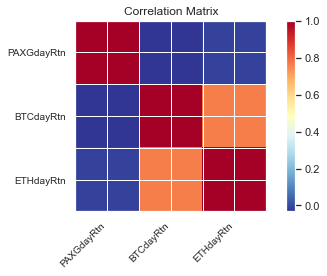

In [67]:
#calculate correlation
correlation = merge.corr()
#plot correlation
sm.graphics.plot_corr(correlation,xnames=list(correlation.columns))
plt.show()

Text(0, 0.5, 'Bitcoin daily returns %')

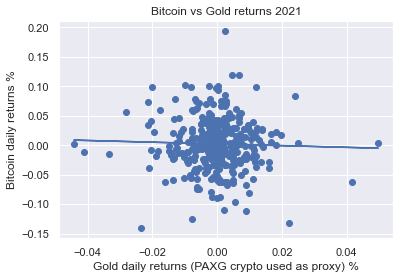

In [73]:
from sklearn.linear_model import LinearRegression

X = pd.DataFrame(merge['PAXGdayRtn'])
y = pd.DataFrame(merge['BTCdayRtn'])

model = LinearRegression(fit_intercept=True)

model.fit(X, y)

y_pred = model.predict(X)

plt.scatter(X, y)

plt.plot(X, y_pred)

plt.title('Bitcoin vs Gold returns 2021')
plt.xlabel('Gold daily returns (PAXG crypto used as proxy) %')
plt.ylabel('Bitcoin daily returns %')

In [74]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     [-0.14561931]
Model intercept: [0.00215929]


In [18]:
merge.index = pd.date_range("1/1/2021", periods=365, freq="d", name="date")

<AxesSubplot:xlabel='PAXGdayRtn', ylabel='BTCdayRtn'>

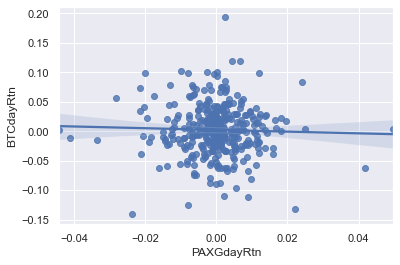

In [19]:
sns.regplot(data=merge, x="PAXGdayRtn", y="BTCdayRtn")

In [76]:
# export as JSON
merge.to_json('/Users/joshhellings/Documents/OneDrive - University of Bristol/Economics Year 3/Data Science/Github Mirror/Portfolio/Data/advPlotting.JSON', orient='records')